# Aerosol Diagnostics Tool

This script compares AOD and DOD from user-specified models with a selection of remotely-sensed products. It currently produces the following types of plots: 

  * timeseries (full timeseries over all years, and mean seasonal cycle)
  * zonal means
  * maps comparing any two models with two observations
  * taylor diagram

User input is required in the "User Input" cell.

## Imports

In [1]:
import importlib
import utilities.datareaders as readers
from utilities.regridder import regridder_global as regrid
from utilities.taylorDiagram import TaylorDiagram

import numpy as np
import xarray as xr
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

from matplotlib.gridspec import GridSpec 
from matplotlib.backends.backend_pdf import PdfPages

import yaml
import calendar
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings(action='ignore',message='Input array is not C_CONTIGUOUS')
warnings.filterwarnings(action='ignore',message='elementwise comparison failed; returning scalar instead,')
warnings.filterwarnings(action='ignore',message='The handle <matplotlib.lines.Line2D object at')

## Setup

In [14]:
# open config file to access user input
with open('config_setup.yaml','r') as f: 
    
    config = yaml.safe_load(f)

    # get model names
    ensembles = config['models']['ensembles']
    singleruns = config['models']['singleruns']
    models = ensembles + singleruns

    # get years over which to plot
    years = np.arange(config['setup']['year_start'],
                      config['setup']['year_end']+1)

    
# the observational products used for model evaluation
sats_aod = ['MODIS Aqua','MISR','CALIOP']
sats_dod = ['MIDAS','CALIOP']
sats = ['MODIS Aqua','MISR','CALIOP','MIDAS']

# set colours to be consistent from plot to plot
cdict_sim = {model:plt.cm.hsv(i/len(models)) for i,model in enumerate(models)}
cdict_obs = {sat:plt.cm.gist_earth(i/len(sats)) for i,sat in enumerate(sats)}
cdict = {**cdict_sim,**cdict_obs}

# set linestyles to be consistent from plot to plot
lsdict_sim = {model:'-' for model in models}
lsdict_obs = {'MODIS Aqua':'--','MISR':':','CALIOP':'-.','MIDAS':'--'}
lsdict = {**lsdict_sim,**lsdict_obs}

## Data readers and processors

In [4]:
def gather_data(var):
    
    with open('config_setup.yaml','r') as f: 
        config = yaml.safe_load(f)
        y0 = config['setup']['year_start']
        yf = config['setup']['year_end']
        expt = config['models']['experiment']
    
    simdata = {}
    
    for model in ensembles:
        simdata[model] = readers.read_ensemble(model,expt,var=var,t0=y0,tf=yf)
        
    for model in singleruns: 
        ds = readers.read_singlefile(model,t0=y0,tf=yf)
        simdata[model] = ds[[var]]
    
    
    if var=='aod':
        obsdata = {'MODIS Aqua':readers.read_modis('Aqua',y0,yf),
                   'MISR':readers.read_misr(y0,yf),
                   'CALIOP':readers.read_caliop('AllSky','Night','aod',y0,yf)}
    
    elif var=='dod':
        obsdata = {'MIDAS':readers.read_midas_01x01(y0,yf),
                   'CALIOP':readers.read_caliop('AllSky','Night','dod',y0,yf)}

    return simdata,obsdata


## Figure Scripts

In [5]:
def plot_timeseries_seasons_combined(var):
    
    f = plt.figure(figsize=(16,4))
    gs = GridSpec(1,2,width_ratios=[2,1])
    ax = np.array([f.add_subplot(gs[0]),f.add_subplot(gs[1])])
    
    ax[0].set_title('%s, %d-%d'%(var.upper(),years[0],years[-1]))
    ax[1].set_title('mean seasonal cycle')
    
    simdata,obsdata = eval('sim%s'%var.upper()), eval('obs%s'%var.upper())
    months = np.arange(1,13,1)
    
    # -- plot sim data ------------------------------------------------------------
    
    for model in simdata.keys():
                
        ds = simdata[model][var]
        if 'run' in ds.dims: ds = ds.chunk(dict(run=-1))
            
        ts = ds.weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat','lon'))   
        ts_season = ts.groupby(ts.time.dt.month).mean('time')
        time = [np.datetime64(t) for t in ts.time.values]
        
        if 'run' in ds.dims:

            ax[0].plot(time,ts.mean('run'),c=cdict[model],ls=lsdict[model],lw=3,label=model)
            ax[1].plot(months,ts_season.median('run'),c=cdict[model],ls=lsdict[model],lw=3,label=model)

            ax[0].fill_between(time,ts.quantile(0.05,'run'),ts.quantile(0.95,'run'),
                               fc=cdict[model],alpha=0.5)
            ax[1].fill_between(months,ts_season.quantile(0.05,'run'),ts_season.quantile(0.95,'run'),
                               fc=cdict[model],alpha=0.5)            
        else:
            
            ax[0].plot(time,ts.values,c=cdict[model],ls=lsdict[model],lw=3,label=model)
            ax[1].plot(months,ts_season.values,c=cdict[model],ls=lsdict[model],lw=3,label=model)
        
        
    # -- plot obs data ------------------------------------------------------------
    
    for sat in obsdata.keys():
        
        ds = obsdata[sat][var]
        ts = ds.weighted(np.cos(np.deg2rad(ds.lat))).mean(('lat','lon'))   
        ts_season = ts.groupby(ts.time.dt.month).mean('time')
        time = [np.datetime64(t) for t in ts.time.values]
            
        ax[0].plot(time,ts,c=cdict[sat],ls=lsdict[sat],lw=3,label=sat)
        ax[1].plot(months,ts_season,c=cdict[sat],ls=lsdict[sat],lw=3,label=sat)    
    
    
    # -- finish fig ------------------------------------------------------------
    
    ax[0].set_ylabel('optical depth')
    ax[1].set_xticks(months[::3])
    ax[1].set_xticklabels([calendar.month_abbr[m] for m in months[::3]])
        
    # force shared y axis
    ylim = ax[0].get_ylim()
    for i in range(2): 
        ax[i].set_ylim(ylim)
    ax[1].set_yticklabels('')
    
    ax[1].legend(loc='upper left',bbox_to_anchor=(1.01,1),
                 bbox_transform=ax[1].transAxes)
        
    plt.subplots_adjust(wspace=0.05)
    
    plt.savefig(pdf_plots,format='pdf')
    plt.show()
    
    return


In [7]:
def plot_zonal_mean(var):
    
    f,ax = plt.subplots(1,figsize=(8,8))
    ax.set_title('Zonal Mean %s (%d-%d mean)'%(var.upper(),years[0],years[-1]))
    
    # -- plot sim and obs data (iterate over both) -------------------------------------

    simdata,obsdata = eval('sim%s'%var.upper()), eval('obs%s'%var.upper())    
    alldata = {**simdata,**obsdata}
    for dataset in alldata.keys():
                
        ds = alldata[dataset][var]
        if 'run' in ds.dims: ds = ds.chunk(dict(run=-1))
        zm = ds.mean(('lon','time'))
            
        if 'run' in ds.dims: 
            ax.plot(zm.lat,zm.mean('run'),c=cdict[dataset],ls=lsdict[dataset],lw=3,label=dataset)
            ax.fill_between(zm.lat,zm.quantile(0.05,'run'),zm.quantile(0.95,'run'),
                            fc=cdict[dataset],alpha=0.5)
        else: 
            ax.plot(zm.lat,zm,c=cdict[dataset],ls=lsdict[dataset],lw=3,label=dataset)
    
    # -- finish fig ------------------------------------------------------------
    
    ax.legend(loc='upper left')
    ax.set_xlabel('latitude')
    ax.set_ylabel(var.upper())
    
    plt.savefig(pdf_plots,format='pdf')
    plt.show()
    
    return


In [8]:
def plot_taylor_fig(var):
    
    f = plt.figure(figsize=(7,6))
    f.suptitle('%d-%d mean %s, all maps regridded to 2x2deg'%(years[0],years[-1],var))
    
    # set up data: time-mean maps, regridded by 2x2 to save computation time
    simdata = {k:regrid(ds[var].mean('time'),res=2) for k,ds in eval('sim%s'%var.upper()).items()}
    obsdata = {k:regrid(ds[var].mean('time'),res=2) for k,ds in eval('obs%s'%var.upper()).items()}
        
    # reference: mean of all obs
    ref = np.nanmean([obsdata[sat].values for sat in obsdata.keys()],axis=0)
    
    # build taylor diagram axes
    ax = TaylorDiagram(np.nanstd(ref),fig=f,rect=111,label='obs mean',srange=(0,3))
    
    # iterate over obs and sims
    for name in tqdm(list(simdata.keys())+list(obsdata.keys())):
        
        ds = simdata[name] if name in models else obsdata[name]
        
        if 'run' in ds.dims:
            for run in ds.run.values: 
                dat = ds.sel(run=run).values
                plot_taylor_point(dat,ref,ax,name,'minor')
            dat = ds.mean('run').values
            plot_taylor_point(dat,ref,ax,name,'major')
        else: 
            dat = ds.values
            plot_taylor_point(dat,ref,ax,name,'major')    
        
    # finish taylor diagram
    ax.add_grid()
    contours = ax.add_contours(levels=5,colors='0.9')
    f.legend(ax.samplePoints, [p.get_label() for p in ax.samplePoints],
             numpoints=1,loc='upper left',bbox_to_anchor=(1,1),bbox_transform=ax._ax.transAxes)
    plt.subplots_adjust(right=0.7)
    
    plt.savefig(pdf_plots,format='pdf')
    plt.show()

    return 


def plot_taylor_point(dat,ref,ax,name,ptype):
    
    # calculate Pearson correlation coefficient (ie how tight is scatter)
    msk = np.isfinite(dat)*np.isfinite(ref)
    std = np.nanstd(dat)
    try: 
        cor = stats.pearsonr(ref[msk],dat[msk])[0]
    except: 
        print(name,np.shape(dat),np.shape(ref))
        cor = stats.pearsonr(ref[msk],dat[msk])[0]
        
    # ptype (point type) = major or minor
    # major is used for ensemble medians and single-realization products (eg obs)
    # minor is used for individual realizations in an ensemble
    
    if ptype=='major':
        mk = 'o' if name in models else 's'
        ax.add_sample(std,cor,c=cdict[name],marker=mk,mec='k',ms=10,ls='',label=name)
    elif ptype=='minor':
        ax.add_sample(std,cor,c=cdict[name],marker='.',alpha=0.5,ms=5,ls='')

    return

In [32]:
def plot_maps_comparisons(model1,model2,obs1,obs2,var):
    
    # plot everything at 1x1 because maps with higher native resolutions 
    # were making the output files way too large
    
    f,ax = plt.subplots(3,3,figsize=(18,9),subplot_kw={'projection':ccrs.PlateCarree()})
    f.suptitle('all maps regridded to 1x1deg')
    
    simdata,obsdata = eval('sim%s'%var.upper()), eval('obs%s'%var.upper())
    absnorm = colors.LogNorm(0.05,1)
    difnorm = colors.SymLogNorm(0.05,1,-0.5,0.5)
    
    for i,model in enumerate([model1,model2]):
        
        ax[i+1,0].set_title('%s %s'%(model,var.upper()))
    
        dsm = simdata[model]
        calc_dims = ('time','run') if 'run' in dsm.dims else 'time'
        dsm = regrid(dsm[var].mean(calc_dims))
        im = ax[i+1,0].pcolormesh(dsm.lon,dsm.lat,dsm,cmap='cividis',norm=absnorm,shading='auto')
        f.colorbar(im,ax=ax[i+1,0],label=var)
    
        for j,obs in enumerate([obs1,obs2]):
             
            dso = regrid(obsdata[obs][var].mean('time'))
            
            if i==0: 
                ax[0,j+1].set_title('%s %s'%(obs,var.upper()))
                im = ax[0,j+1].pcolormesh(dso.lon,dso.lat,dso,cmap='cividis',norm=absnorm,shading='auto')
                f.colorbar(im,ax=ax[0,j+1],label=var)
        
            ax[i+1,j+1].set_title('%s minus %s'%(model,obs))
            dif = dsm - dso
            im = ax[i+1,j+1].pcolormesh(dif.lon,dif.lat,dif,cmap='coolwarm',norm=difnorm,shading='auto')
            f.colorbar(im,ax=ax[i+1,j+1],label='%s dif'%var)

    ax[0,0].axis('off')
    ax[0,0].text(0.15,0.8,'observations',transform=ax[0,0].transAxes,fontsize=12)
    ax[0,0].text(0.15,0.45,'models',transform=ax[0,0].transAxes,fontsize=12)
    ax[0,0].annotate('',xy=(0.2,0.05),xytext=(0.2,0.4),xycoords='axes fraction',arrowprops={'width':1,'fc':'k'})
    ax[0,0].annotate('',xy=(0.9,0.8),xytext=(0.5,0.8),xycoords='axes fraction',arrowprops={'width':1,'fc':'k'})
    for a in ax.flat[1:]: a.coastlines()
        
    plt.savefig(pdf_plots,format='pdf')
    plt.show()
    
    return


## Main 

In [ ]:
with open('config_setup.yaml','r') as f: 
    
    config = yaml.safe_load(f)
    savename = config['setup']['savename']
    variables = config['setup']['variables']
    comparemaps = config['models']['comparemaps']

pdf_plots = PdfPages(savename)

In [11]:
# read in data
if 'aod' in variables: 
    simAOD,obsAOD = gather_data('aod')
if 'dod' in variables: 
    simDOD,obsDOD = gather_data('dod')

reading MODIS-Aqua AOD from 2014 to 2015
progress bar = years


  0%|          | 0/2 [00:00<?, ?it/s]

reading MISR AOD from 2014 to 2015
progress bar = years


  0%|          | 0/2 [00:00<?, ?it/s]

reading CALIOP-AllSky-Night aod from 2014 to 2015
progress bar = years


  0%|          | 0/2 [00:00<?, ?it/s]

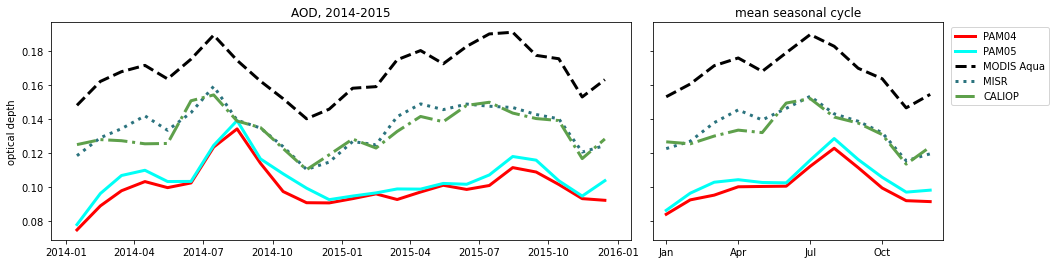

In [34]:
for var in variables:
    plot_timeseries_seasons_combined(var)

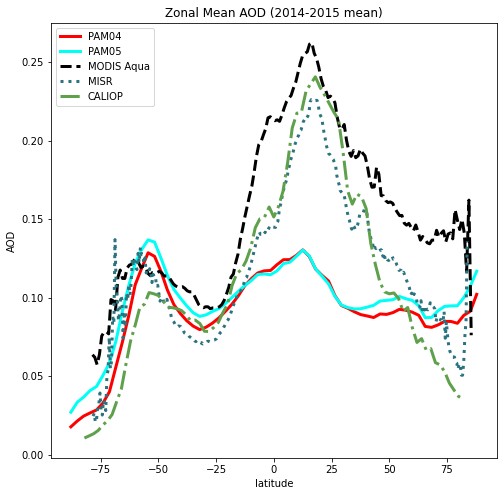

In [35]:
for var in variables: 
    plot_zonal_mean(var)

/home/digbyr/anaconda3/envs/aer_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/5 [00:00<?, ?it/s]

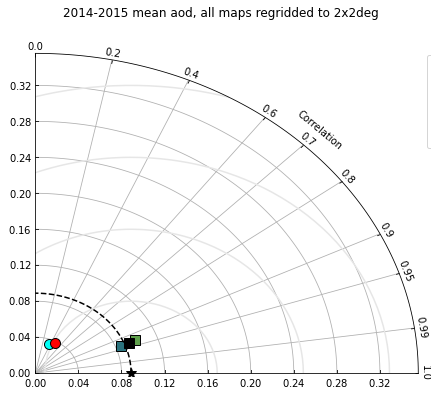

In [36]:
# Note that this figure will likely appear distorted in the notebook
# but it will be properly proportioned in the output pdf. 
for var in variables:
    plot_taylor_fig(var)

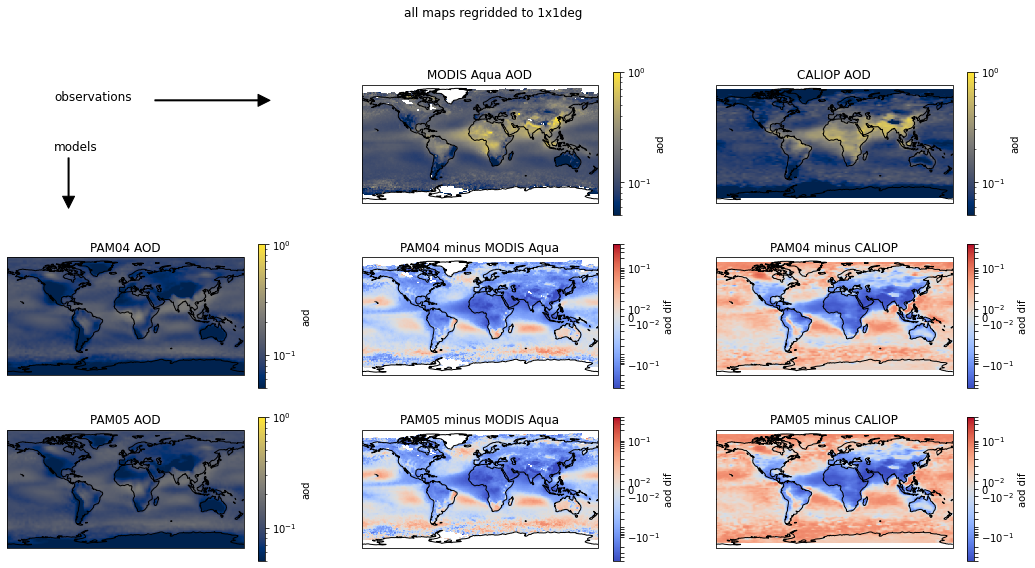

In [37]:
for [model1,model2,var] in comparemaps:
    if var=='aod': obs1,obs2 = 'MODIS Aqua','CALIOP'
    elif var=='dod': obs1,obs2 = 'MIDAS','CALIOP'
    plot_maps_comparisons(model1,model2,obs1,obs2,var)

In [38]:
pdf_plots.close()